### Load Data and libraries

In [12]:
import numpy as np
import pandas as pd
from pandas import read_csv
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import math

In [86]:
# Load data
data = read_csv(r"C:\Users\zhouq\OneDrive - Nanyang Technological University\FYP\Codes\FYP\Data_transform.csv", header = 0,  index_col=0, parse_dates=True, dayfirst=False)

# Select 3 exogenous variables 
data_new = data[['GDP', 'M1', 'M7','M12']]
data_new = data_new.dropna()
display(data_new)

# Split the data into training and testing sets
train_size = int(len(data_new) * 0.8)
train, test = data_new[:train_size], data_new[train_size:]

#normalize data
def normalize_train_test(train, test, return_mu_sig=False):
    m_train = train.mean()
    s_train = (train - train.mean()).std()
    if return_mu_sig:
        return (train - m_train)/s_train, (test - m_train)/s_train, m_train, s_train
    else:
        return (train - m_train)/s_train, (test - m_train)/s_train
    
train_norm, test_norm, mu, sig = normalize_train_test(train, test, return_mu_sig=True)

,GDP,M1,M7,M12
Date,,,,
1959-06-30,0.022301,0.012391,0.005828,0.196667
1959-09-30,0.000705,-0.019971,-0.002374,0.123333
1959-12-31,0.002845,0.019589,-0.008020,0.076667
1960-03-31,0.022228,0.002654,0.009733,-0.050000
1960-06-30,-0.005405,-0.007252,0.003164,-0.173333
...,...,...,...,...
2018-12-31,0.002229,-0.000848,-0.002520,0.106667
2019-03-29,0.005960,-0.003236,0.009089,0.046667
2019-06-28,0.007898,-0.001557,0.003632,-0.010000


### ARX Model

In [87]:
# Define and fit the ARX model
order = (1, 0, 0)  # AR(1)
model = ARIMA(endog=train_norm[['GDP']], exog=train_norm.iloc[:, 1:], order=order)
fit = model.fit(method='yule_walker')

c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


#### Fixed parameter point forecast

In [88]:
# make predictions - one step ahead forecast
forecast = fit.predict(start=len(train), end=len(data_new)-1, exog=test_norm.iloc[:, 1:])

for i in range(0, len(forecast)):
    forecast[i] = forecast[i]*sig[0]+mu[0]

# one step ahead forecast
# fore_1 = fit.forecast(steps=1, exog=test.iloc[0:3, 1:])

In [89]:
# Evaluate the model 
mse = mean_squared_error(test['GDP'], forecast)
print('MSE: '+str(mse))

mae = mean_absolute_error(test['GDP'], forecast)
print('MAE: '+str(mae))

rmse_f = math.sqrt(mean_squared_error(test['GDP'], forecast))
print('RMSE: '+str(rmse_f))

MSE: 2.578817302342964e-05
MAE: 0.0036854222576466335
RMSE: 0.005078205689358166


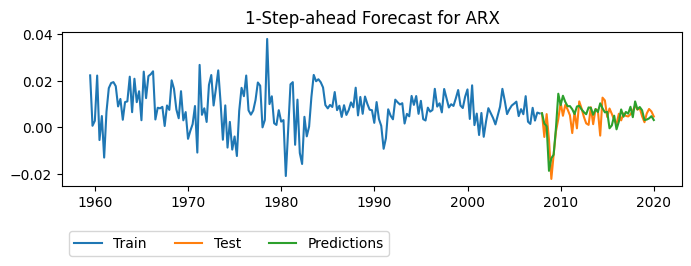

In [90]:
# Plot the actual vs. predicted values
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(train)], train['GDP'], label='Train')
plt.plot(data_new.index[len(train):], test['GDP'], label='Test')
plt.plot(data_new.index[len(train):], forecast, label='Predictions')
plt.title("1-Step-ahead Forecast for ARX")
plt.legend(bbox_to_anchor=(0, -0.5), loc='lower left', ncol =3)
plt.show()

#### Expanding window forecast

In [97]:
hist_exo = train_norm.iloc[:, 1:].copy(deep=True)
hist_endo = pd.DataFrame(train_norm['GDP'].copy(deep=True))
fore_ew = list()
 
for t in range(len(test)):
 # model set up and fit
 model = ARIMA(endog=hist_endo, exog=hist_exo, order=order)
 fit = model.fit(method='yule_walker')

 #point forecast -- undo norm
 output = fit.forecast(steps=1, exog = test_norm.iloc[t,1:])*sig[0] + mu[0]
 
 # update training dataset with observed data
 hist_exo = hist_exo._append(test_norm.iloc[t, 1:],ignore_index=True)
 new_value = test_norm.iloc[t,0]
 new_row = {col: new_value for col in hist_endo.columns}
 hist_endo = hist_endo._append(new_row, ignore_index=True)
 
 # add forecast value to list
 fore_ew.append(output) 
 # obs = test.iloc[t,0] # actual
 # print('predicted=%f, actual=%f' % (output, obs))
 
# evaluate forecasts
rmse_ew = math.sqrt(mean_squared_error(test['GDP'], fore_ew))
print('RMSE: '+str(rmse_ew))



c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


RMSE: 0.005082880258738569


In [92]:
# check if hist_endo append correctly
df1_reset = hist_endo.reset_index(drop=True)
df2_reset = data_new['GDP'].reset_index(drop=True)
equal_ignoring_index = df1_reset.equals((df2_reset).to_frame())
print(equal_ignoring_index)

False


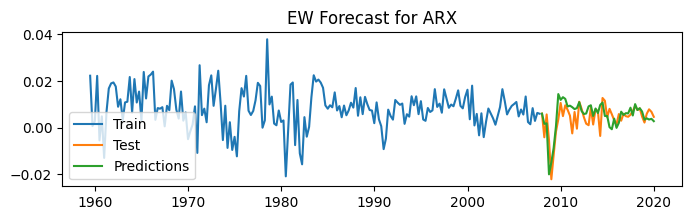

In [98]:
# plot forecasts against actual outcomes
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(train)], train['GDP'], label='Train')
plt.plot(data_new.index[len(train):], test['GDP'], label='Test')
plt.plot(data_new.index[len(train):], fore_ew, label='Predictions')
plt.title("EW Forecast for ARX")
plt.legend()
plt.show()


#### Rolling window forecast

In [94]:
hist_exo_rw = train_norm.iloc[:, 1:].copy(deep=True)
hist_endo_rw = pd.DataFrame(train_norm['GDP'].copy(deep=True))

fore_rw = []

import warnings
# Ignore ValueWarning
warnings.filterwarnings("ignore")

for t in range(len(test)):
 # model set up and fit
 model = ARIMA(endog=hist_endo_rw, exog=hist_exo_rw, order=order)
 fit = model.fit(method='yule_walker')
 output = fit.forecast(steps=1, exog = test_norm.iloc[t,1:])*sig[0] + mu[0]
 
 # update training dataset with observed data
 hist_exo = hist_exo.iloc[1:]._append(test_norm.iloc[t, 1:],ignore_index=True)
 new_value = test_norm.iloc[t,0]
 new_row = {col: new_value for col in hist_endo.columns}
 hist_endo = hist_endo.iloc[1:]._append(new_row, ignore_index=True)
 
 fore_rw.append(output) 

warnings.resetwarnings()

In [95]:
# evaluate forecasts
rmse_rw = math.sqrt(mean_squared_error(test['GDP'], fore_rw))
print('RMSE: '+str(rmse_rw))

RMSE: 0.005119700291684519


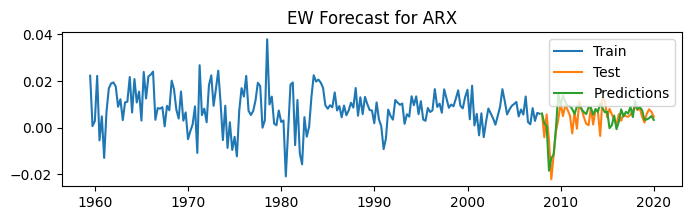

In [96]:
# plot forecasts against actual outcomes
plt.figure(figsize=(8,2))
plt.plot(data_new.index[:len(train)], train['GDP'], label='Train')
plt.plot(data_new.index[len(train):], test['GDP'], label='Test')
plt.plot(data_new.index[len(train):], fore_rw, label='Predictions')
plt.title("EW Forecast for ARX")
plt.legend()
plt.show()


#### Summary of RMSE for one step ahead

In [99]:
rmse_sum = {'Forecast Methods': ['Fixed Parameters', 'Expanding Window', 'Rolling Window'], 
            'RMSE': [rmse_f, rmse_ew, rmse_rw ]}

print(pd.DataFrame(rmse_sum).to_string(index=False))

Forecast Methods     RMSE
Fixed Parameters 0.005078
Expanding Window 0.005083
  Rolling Window 0.005120


### Direct multi-step forecast

In [117]:
model_arx = ARIMA(endog=train_norm[['GDP']], exog=train_norm.iloc[:, 1:], order=order)
fit_arx = model.fit(method='yule_walker')

c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


In [130]:
data = [train, test]
display(data[0]['GDP'])
display(data[0].iloc[:, 1:])

Date
1959-06-30    0.022301
1959-09-30    0.000705
1959-12-31    0.002845
1960-03-31    0.022228
1960-06-30   -0.005405
                ...   
2006-09-29    0.001503
2006-12-29    0.008402
2007-03-30    0.002932
2007-06-29    0.006364
2007-09-28    0.006005
Name: GDP, Length: 194, dtype: float64

,M1,M7,M12
Date,,,
1959-06-30,0.012391,0.005828,0.196667
1959-09-30,-0.019971,-0.002374,0.123333
1959-12-31,0.019589,-0.008020,0.076667
1960-03-31,0.002654,0.009733,-0.050000
1960-06-30,-0.007252,0.003164,-0.173333
...,...,...,...
2006-09-29,0.000686,0.001006,0.086667
2006-12-29,0.002802,0.004399,-0.003333
2007-03-30,0.002561,0.003127,0.006667


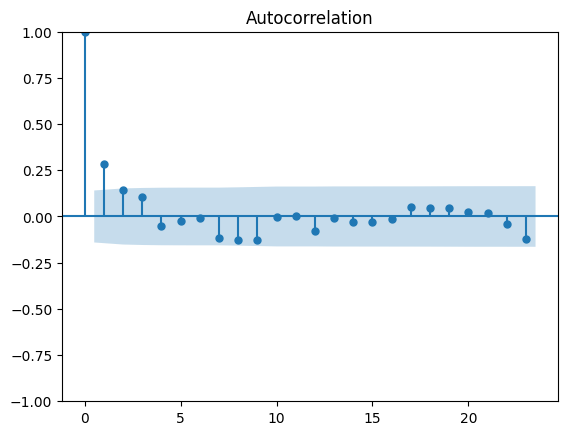

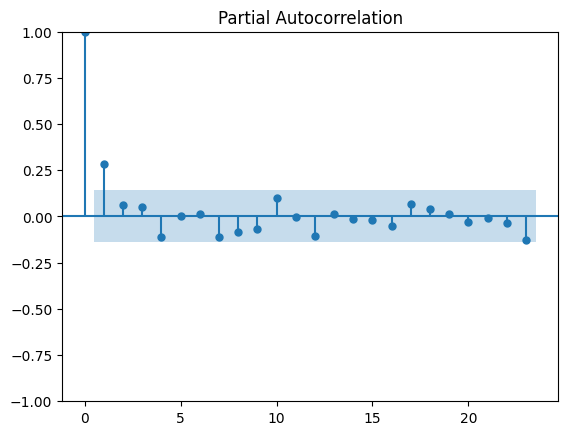

In [192]:
# use acf and pacf to predict exogeneous variables
# For M1: Industrial Production Index
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train.iloc[:,1]) #MA(3)
plot_pacf(train.iloc[:,1]) #AR(1)
plt.show()

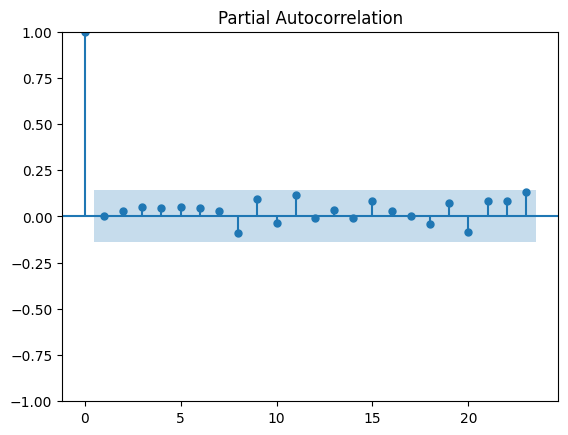

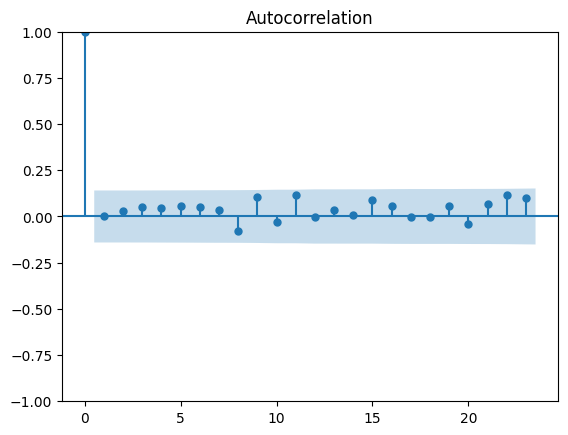

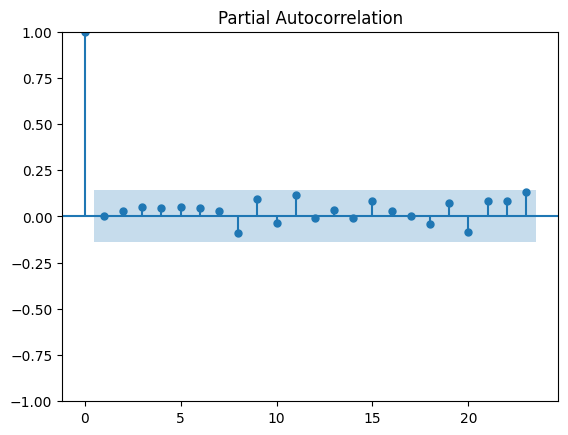

In [193]:
# for M7: Retail and Food Services Sale
plot_acf(train.iloc[:,2]) #MA(1)
plot_pacf(train.iloc[:,2]) #AR(1)

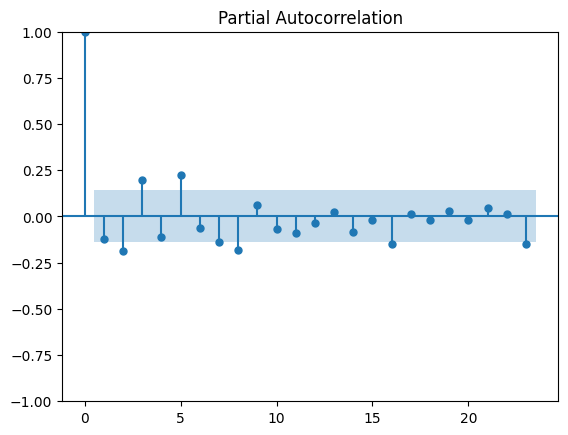

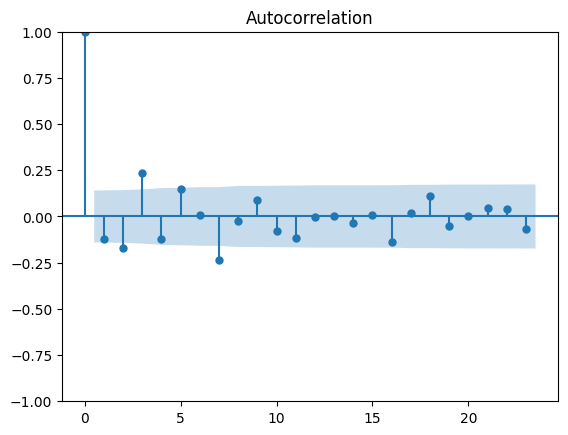

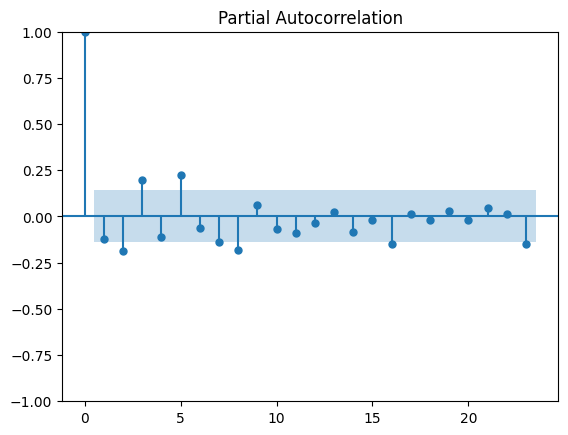

In [194]:
# M12: Effective Federal Funds Rate
plot_acf(train.iloc[:,3]) #MA(3)
plot_pacf(train.iloc[:,3]) #AR(3)

In [152]:
# make predictions - 8 steps ahead forecast
def arx_multistep(steps, data):
    GDP_data_train = data[0]['GDP']
    GDP_data_test = data[1]['GDP']
    x_train, x_test = data[0].iloc[:, 1:], data[1].iloc[:, 1:]
    GDP_test_dates = GDP_data_test.index

    GDP_data_train, GDP_data_test, GDP_mu_train, GDP_sig_train = (
        normalize_train_test(GDP_data_train, GDP_data_test, 
            return_mu_sig=True)
    )

    x_train, x_test = normalize_train_test(x_train, x_test)

    #set up ARX model forecast
    model_arx = ARIMA(endog=train_norm[['GDP']], exog=train_norm.iloc[:, 1:], order=order)

    fit_arx = model.fit(method='yule_walker')

    forecast_multistep = np.zeros((len(GDP_test_dates), steps))

    for j in range (len(GDP_data_test)):
        if (j +steps) <= len(GDP_data_test):
            forecast_multistep[j, :] = fit.forecast(steps= steps, exog = x_test.iloc[j:j+steps,:])*GDP_sig_train + GDP_mu_train

        else:
            # include exo AR terms

    return pd.DataFrame(data=forecast_multistep, index=GDP_test_dates, columns=range(steps))




In [154]:
arx_multi_fore = arx_multistep(steps =8, data=[train, test])
arx_multi_fore

c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


,0,1,2,3,4,5,6,7
Date,,,,,,,,
2007-12-31,0.006041,0.001676,0.000496,-0.018602,-0.013195,-0.011672,-0.000224,0.014442
2008-03-31,0.001921,0.000433,-0.018586,-0.013199,-0.011671,-0.000224,0.014442,0.009537
2008-06-30,0.000678,-0.018649,-0.013183,-0.011675,-0.000223,0.014441,0.009537,0.013579
2008-09-30,-0.018404,-0.013246,-0.011659,-0.000227,0.014442,0.009537,0.013579,0.010963
2008-12-31,-0.013001,-0.011722,-0.000211,0.014438,0.009538,0.013579,0.010963,0.009078
2009-03-31,-0.011477,-0.000274,0.014454,0.009534,0.013580,0.010963,0.009078,0.009129
2009-06-30,-0.000029,0.014392,0.009550,0.013576,0.010964,0.009078,0.009129,0.007793
2009-09-30,0.014637,0.009487,0.013592,0.010960,0.009079,0.009129,0.007793,0.005713
2009-12-31,0.009732,0.013529,0.010976,0.009075,0.009130,0.007793,0.005713,0.008960


In [160]:
def hStepRMSFE(forecasts_df):
    T = len(forecasts_df)
    steps = len(forecasts_df.columns)
    hStep_rmse = np.zeros((steps))
    for h, c in enumerate(forecasts_df.columns):
        hStep_rmse[h] = np.sqrt(np.mean(np.square(
            np.squeeze(test.iloc[:,0].to_numpy()) - forecasts_df[[c]].to_numpy()
        )[h:(T-steps+h+1)]))
    return pd.DataFrame(data=hStep_rmse, index=range(1, 1+steps))


In [176]:
hStepRMSFE(arx_multi_fore)

,0
1,0.008889
2,0.008898
3,0.008207
4,0.007390
5,0.007216
6,0.007048
7,0.006957
8,0.006923


In [177]:
hStepRMSFE(arx_multi_fore.iloc[0:len(arx_multi_fore) -8+1,:])


,0
1,0.009208
2,0.009186
3,0.008369
4,0.007459
5,0.007285
6,0.007072
7,0.006929
8,0.006853


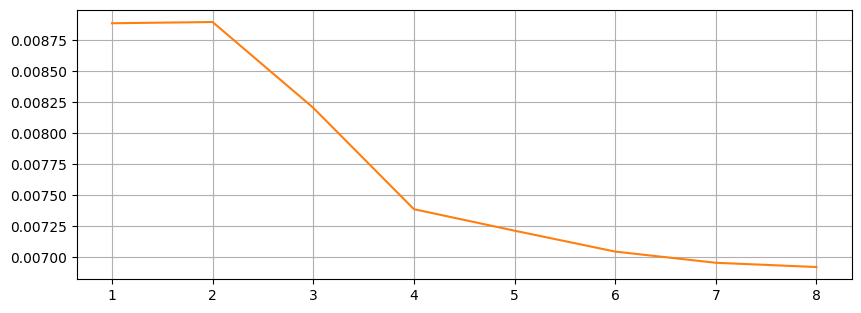

In [180]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.grid()
plt.plot(hStepRMSFE(arx_multi_fore), label="ARX", c="C1") 

# VAR